# Install Transformers Library

In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.9MB/s 
     |████████████████████████████████| 1.1MB 20.0MB/s 
     |████████████████████████████████| 890kB 29.3MB/s 
     |████████████████████████████████| 2.9MB 45.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b928f76ce17bcb8cac2b3879fa0a461a6c338faea37519ff56471bdc181160b7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [3]:
df_cleaned = pd.read_csv('/content/Cleaned_Dataset.csv')
print(df_cleaned.columns)

Index(['ID', 'Text', 'Pronoun', 'Pronoun-offset', 'A', 'A-offset', 'A-Coref',
       'B', 'B-offset', 'B-Coref', 'Unnamed: 10'],
      dtype='object')


In [4]:
df_cleaned = df_cleaned[df_cleaned['Pronoun'].isin(['he','she'])]

In [7]:
df_winnow = pd.read_json('/content/winnow_train_s.jsonl',lines=True)
print(df_winnow.columns)

Index(['qID', 'sentence', 'option1', 'option2', 'answer'], dtype='object')


In [8]:
print(df_winnow['sentence'][5])

Kyle doesn't wear leg warmers to bed, while Logan almost always does. _ is more likely to live in a warmer climate.


In [10]:
for idx, row in df_winnow.iterrows():
  if '_' in row['sentence']:
    sent = row['sentence'].split('.')
    sent_single = " ".join(sent)
    sent_single +="."
    if idx %2 == 0:
      df_winnow.at[idx,'sentence2'] = sent_single.replace('_', 'he')
    else:
      df_winnow.at[idx,'sentence2'] = sent_single.replace('_', 'she')
  else:
    print(sent_single)
    df_winnow.at[idx,'sentence2'] = sent_single


In [11]:
print(df_winnow['sentence2'][5])

Kyle doesn't wear leg warmers to bed, while Logan almost always does  she is more likely to live in a warmer climate .


In [12]:
for idx, rows in df_cleaned.iterrows():
  if rows['A-Coref'] == True:
    df_cleaned.loc[idx,'answer'] = 0
  else:
    df_cleaned.loc[idx,'answer'] = 1

df_cleaned['answer'] = df_cleaned['answer'].astype(np.int64)
df_winnow['answer'] = df_winnow['answer'] - 1

In [13]:
Win_X_train, Win_X_test, Win_y_train, win_y_test = train_test_split(df_winnow['sentence'], df_winnow['answer'],
                                                    stratify=df_winnow['answer'], 
                                                    test_size=0.80)


In [14]:
print(len(Win_X_train), len(Win_X_test), len(Win_y_train), len(win_y_test))

128 512 128 512


In [15]:
cleaned_train_data = df_cleaned[['Text','answer']]
cleaned_train_data = cleaned_train_data.rename(columns={'Text':'sentence'})
print(len(cleaned_train_data))

6144


In [16]:
final_data = pd.DataFrame()

In [17]:
final_data['sentence'] = cleaned_train_data['sentence'].append(Win_X_train,ignore_index=True)
final_data['answer'] = cleaned_train_data['answer'].append(Win_y_train,ignore_index=True)
print(len(final_data['sentence']),len(final_data['answer']))

6272 6272


# Split train dataset into train, validation and test sets

In [18]:
train_text, val_text, train_labels, val_labels = train_test_split(final_data['sentence'], final_data['answer'], 
                                                                    random_state=2020, 
                                                                    test_size=0.2, 
                                                                    stratify=final_data['answer'])

# Import BERT Model and BERT Tokenizer

In [56]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenization

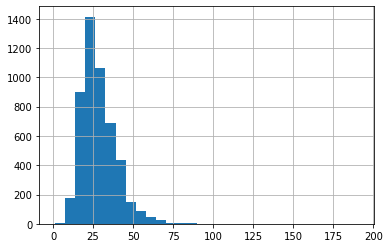

In [57]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [58]:
max_seq_len = 25

In [59]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
   train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    Win_X_test.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [60]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(win_y_test.tolist())

# Create DataLoaders

In [61]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [62]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [63]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [64]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [65]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.001)

# Find Class Weights

In [66]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.75420926 1.48344175]


In [68]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 25

# Fine-Tune BERT

In [69]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [70]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = time.time() - t0
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      # print(preds,labels)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [71]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/bertsaved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 25
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...

Training Loss: 0.720
Validation Loss: 0.699

 Epoch 2 / 25
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...

Training Loss: 0.693
Validation Loss: 0.694

 Epoch 3 / 25
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...

Training Loss: 0.694
Validation Loss: 0.694

 Epoch 4 / 25
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...

Training Loss: 0.693
Validation Loss: 0.693

 Epoch 5 / 25
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...

Training Loss: 0.692
Validation Loss: 0.694

 Epoch 6 / 25
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...

Training Loss: 0.693
Validation Loss: 0.693

 Epoch 7 / 25
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  

# Load Saved Model

In [37]:
#load weights of best model
path = '/content/bertsaved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [38]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [39]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.50      0.91      0.64       256
           1       0.45      0.07      0.13       256

    accuracy                           0.49       512
   macro avg       0.47      0.49      0.38       512
weighted avg       0.47      0.49      0.38       512

